# Investigating Fake News on Facebook

In [25]:
#import import_ipynb
import math
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns # for visualiation
import matplotlib.pyplot as plt # plotting
import matplotlib

## Supress warnings thrown by any of the models
from sklearn.exceptions import DataConversionWarning
from sklearn.exceptions import ConvergenceWarning
from sklearn import warnings
import warnings
from IPython.display import Image
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

matplotlib.style.use('ggplot')
%matplotlib inline
import altair as alt
alt.renderers.enable('notebook')

df = pd.read_csv('./facebook_with_reactions.csv')
outcomes = df[['Rating']]
graphing_data = df.copy()
## drop useless columns 
df = df.drop(columns=['Debate', 'status_link', 'permalink_url', 'Post URL', 
                      'status_message', 'link_name', 'share_count', 'Unnamed: 0', 'account_id',
                      'status_id', 'status_type', 'status_published', 'post_id', 'reaction_count', 'Date Published'])

# new columns
df['Popular'] = df.num_comments + df.num_likes + df.num_shares

## change Rating to numeric for classification
df['Rating'] = df.Rating.replace(['mostly false', 'no factual content', 'mixture of true and false', 'mostly true'], [0,1,2,3])
df['Rating2'] = df.Rating.replace([0,1,2,3], [0,0,0,1]).astype(int)

## remove spaces in columns
df.columns = [c.replace(' ', '_') for c in df.columns]

# get dummy variables for categorical columns
df = pd.get_dummies(df)

In [26]:
from sklearn.model_selection import train_test_split

# train and test data that uses 4 categories for Ranking (our outcome variable)
tr_feat, test_feat, tr_out, test_out = train_test_split(
   df.drop(columns=['Rating', 'Rating2']),      # features
   df.Rating,    # outcome
   random_state=0,
   test_size=0.20, # percentage of data to use as the test set
   
)

# train and test data that uses 2 categories for outcome variable
tr2_feat, test2_feat, tr2_out, test2_out = train_test_split(
   df.drop(columns=['Rating', 'Rating2']),      # features
   df.Rating2,    # outcome
   random_state=0,
   test_size=0.20, # percentage of data to use as the test set
   
)

## Purpose

The purpose of this Notebook is to demonstrate the process we went through to answer our research question. We wanted to explore Facebook post popularity and its relationship with Fake News. Specifically, we wanted to know if there was a relationship between popularity and Fake News and take that a step further and see if we can predict if something is misinformation based on its popularity in addition to some other factors. To do so, we found a data set on Kaggle that takes posts from Facebook pages for news sources. The data contains posts from sources that are "left-wing", "right-wing" and mainstream. Additionally, the data contains a feature that gives each post a rating of how truthful the post is. The categories within that feature are `mostly false`, `mostly true`, `mixture of true/false`, and `no factual content`. These ratings were determined by BuzzFeed and as far as we know no other source. This does raise concern in regards to how much we can trust the determination of truthfulness from a single source. There could be implicit biases introduced as a result. Beyond this, the data contains other pertinent information ranging from type/number of reactions to a post, which page posted it, the category that page falls under, and the type of post.  

## Exploratory Data Analysis

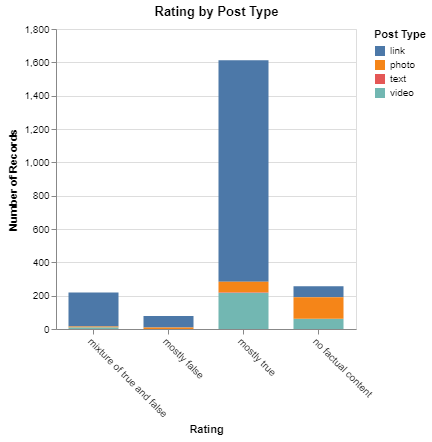

In [15]:
# plot that shows counts of ratings colored based on the type of post i.e. video, link, text, etc.
alt.Chart(graphing_data).mark_bar(size=50).encode(
    alt.X('Rating', axis=alt.Axis(format='%', title='Rating', labelAngle=45)),
    y='count()',
    color='Post Type'
).properties(width=300, height=300, title='Rating by Post Type')

The majority of observations in our dataset consist of articles that are 'mostly true'. This could pose as an issue because an imbalance of data could throw off our model as well as make it difficult to analyze/trust the trends in our data. Additionally, the focus of our research is to predict occurences of "fake news" within news sources on Facebook so we have to be sure that our data and models do so accurately. This means we will most likely need to find a way to weight outcomes beside `mostly true` to help balance the data as well as further wrangling of the data to offset the imbalance. 

The primary source of our Facebook posts consist of links that send a user to an external article or site. Knowing this could prove to be important because this means that most of the content on these posts isn't served directly on Facebook. This could introduce bias as to whether Facebook users are actually viewing the content or just reacting to headlines, comments, and opinions rather than actually reading the article. As a result, content that may not be truthful could be posted within these pages without people knowing. 

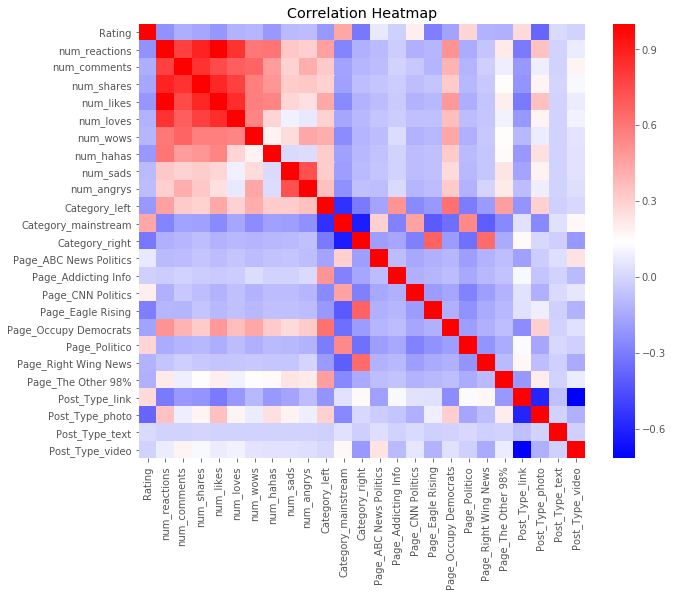

In [16]:
df_temp = df.drop(columns=['comment_count', 'Rating2', 'Popular'])
plt.figure(figsize = (10,8))
corr = df_temp.corr()
ax = plt.axes()
ax.set_title('Correlation Heatmap')
sns.heatmap(corr, cmap='bwr', ax = ax,
        xticklabels=corr.columns,
        yticklabels=corr.columns);

Looking at a heatmap of our features, we can gain some quick insight into which ones have high correlations with our outcome of interest. At first glance, we can see that there is a moderate correlation between `Rating` and `Category_mainstream`. This could mean that mainstream articles tend to be more truthful or include more fake news and would be important to analyze. The only other positive correlations relating to _rating_ are whether the page is from the _Politico_ page and if the type of post is a _link_. Looking at the `category` features there seems to be a strong relationship between "left-wing" posts and the number/type of reactions. This could mean that generally speaking left-wing posts are more popular but not necessarily more truthful. 

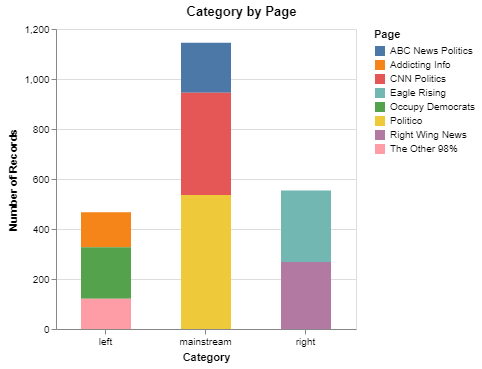

In [17]:
alt.Chart(graphing_data).mark_bar(size=50).encode(
    alt.X('Category', axis=alt.Axis(format='%', title='Category', labelAngle=0)),
    y='count()',
    color='Page'
).properties(width=300, height=300, title='Category by Page')

The pages that made posts contained in our dataset consist of three _mainstream_ media sites, three _left_ leaning sites, and two _right_ leaning sites. It should be noted, that during the time of this analysis, the two right leaning sites, _Right Wing News_ and _Eagle Rising_, could no longer be found anywhere on either facebook or through google searches. This suggests that facebook has been getting more diligent in terms of locating and eliminating fake news on their site.

Contained in the data is an almost equal amount left and right leaning articles, with almost double the amount of mainstream articles.

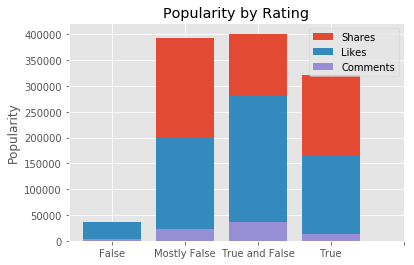

In [18]:

p1 = plt.bar(df.Rating, df.num_shares)
p2 = plt.bar(df.Rating, df.num_likes)
p3 = plt.bar(df.Rating, df.num_comments)

ind = np.arange(5)

plt.ylabel('Popularity')
plt.title('Popularity by Rating')

plt.xticks(ind, ('False', 'Mostly False', 'True and False', 'True'))

plt.legend((p1[0], p2[0], p3[0]), ('Shares', 'Likes', 'Comments'))

plt.show()

The most popular posts contained in the dataset are those that are 'mostly false' and a 'mixture of true and false'. While the differences between the popularity of posts that contain no factual content and those that contain some factual content is quite large, this is mostly due to the pages that post exclusively false content have substantially less followers than those pages that post a mix of true and untrue content.

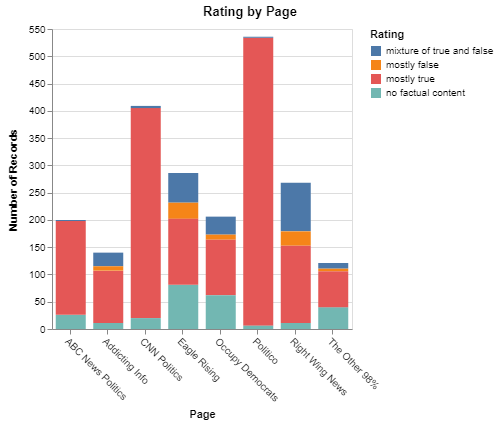

In [19]:
# Plot showing the amount of posts each source made in each "Rating"
alt.Chart(graphing_data).mark_bar(size=30).encode(
    alt.X('Page', axis=alt.Axis(format='%', title='Page', labelAngle=45)),
    y='count()',
    color='Rating'
).properties(width=300, height=300, title='Rating by Page')

While the majority of posts by each of the pages are considered to be mostly true, we can see that some pages do post a substantial amount more news that contains _no factual content_ than others, and some pages, like Politico, seem to post almost exlusively _mostly true_ articles. The mainstream sites like ABC News and CNN post mostly factually correct news, but occasionally have articles that contain no factual content whatsoever. 

It should be noted that the sites that could no longer be found on facebook or google, _Right Wing News_ and _Eagle Rising_, while still posting _mostly_ articles that contain true content, still posted the most content that was either a mixture of true and false, or mostly false.

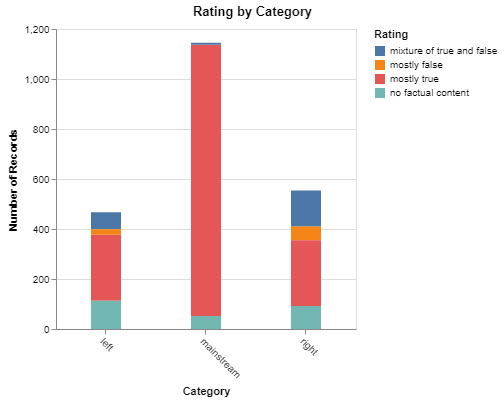

In [20]:
# Plot showing the amount of posts each source made in each "Rating"
alt.Chart(graphing_data).mark_bar(size=30).encode(
    alt.X('Category', axis=alt.Axis(format='%', title='Category', labelAngle=45)),
    y='count()',
    color='Rating'
).properties(width=300, height=300, title='Rating by Category')

As what might be expected, mainstream media posts predominatly true content, while the more left and right leaning pages post more of a mixture of content. The right-wing sights contained in our dataset do have _more_ records that are considered fake news, but this is mostly because they have more total records. Looking at the number of 'mostly true'and 'no factual content' articles for both left and right wing pages, we can see that they bost post an equal amount of correct news and fake news.

## Feature Engineering and Selection

### Statistical Analysis 

In [27]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='sag',
                         multi_class='multinomial').fit(tr_feat, tr_out)

clf2 = LogisticRegression(random_state=0, solver='sag',
                         multi_class='multinomial').fit(tr2_feat, tr2_out)

In [28]:
from sklearn.metrics import classification_report
tar = ['mostly false', 'no factual content', 'mixture of true and false', 'mostly true']

pred = clf.predict(test_feat)
print('Using four classes:\n')
print(classification_report(test_out, pred, target_names=tar))

print('-------------------------------------------------------------------\n')
print('Using two classes:\n')
pred = clf2.predict(test2_feat)
print(classification_report(test2_out, pred, target_names=['False', 'True']))

Using four classes:

                           precision    recall  f1-score   support

             mostly false       0.00      0.00      0.00        15
       no factual content       0.61      0.22      0.33        63
mixture of true and false       0.30      0.07      0.12        42
              mostly true       0.76      0.97      0.86       314

                micro avg       0.74      0.74      0.74       434
                macro avg       0.42      0.32      0.32       434
             weighted avg       0.67      0.74      0.68       434

-------------------------------------------------------------------

Using two classes:

              precision    recall  f1-score   support

       False       0.69      0.35      0.46       120
        True       0.79      0.94      0.86       314

   micro avg       0.78      0.78      0.78       434
   macro avg       0.74      0.64      0.66       434
weighted avg       0.76      0.78      0.75       434



Using Logistic Regression we can see how well this statistical model is able to predict outcomes. With the four-class outcome it is unable to accurately predict any of the _mostly false_ articles. It does however do well decent with predicting _mostly true_ cases. Ultimately we want a model that can predict at least to some degree if an article is "fake news." To do this we also performed Logistic Regression on a model that uses two classes for the outcome. Here we do see the model is predicting some false cases because we now have `no factual content` and `mixture of true and false` included there. 

In [30]:
#R code, OLR from MASS Package
###Do not run
model_data$Rating=as.factor(model_data$Rating)
full=polr(Rating~., data=model_data)

step(full, data=model_data, direction="backward")

#AIC=279-.518
#Residual Deviance=2752.518
best_model2<-polr(formula = Rating ~ comment_count + num_reactions + num_comments + 
                    num_likes + num_loves + num_hahas + num_sads + num_angrys + 
                    Category_left + Category_mainstream + `Page_ABC News Politics` + 
                    `Page_CNN Politics` + `Page_Eagle Rising` + `Date_Published_2016-09-23` + 
                    Post_Type_link + Post_Type_photo, data = model_data)

y_pred2=predict(best_model2,data=model_data)
accur2=0
for(i in 1:length(y_pred2)){
  if(model_data$Rating[i]==y_pred2[i]){
    accur2=accur2+1
  }
}
accur2/length(y_pred2) #0.7811

SyntaxError: invalid syntax (<ipython-input-30-78181d90560c>, line 3)

In [ ]:
#Here is the result from Ordinal Logistic Regression, with AIC=2790.518 and Residual Deviance=2752.518
Image(filename='OLS_R_output.PNG')

## Machine Learning Models

### KNN Classifier
- Justin

In [ ]:
import KNN as k;

In [ ]:
cols = list(tr2_feat.columns.values)
features = []
for bool, feature in zip(k.rfe.support_, cols):
    if bool:
        features.append(feature)
knn_train_features = tr2_feat[features]
knn_test_features = test2_feat[features]

In [ ]:
k.knn_grid.fit(knn_train_features, tr2_out)
k.knn_grid.score(knn_test_features, test2_out)

In [ ]:
plt.title('KNN Model With Two Classes')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.scatter(k.knn_grid.predict(knn_test_features), test2_out)
plt.show();

In [ ]:
sns.stripplot(x=k.knn_grid.predict(knn_test_features), y=test2_out, jitter=True, dodge=True, alpha=0.5);

### Random Forest Classifier
- In Random Forest Classifier, we are trying to build a model using parameters that would give us the highest accuracy. I have written some helper function that would help selecting features using ExtraTreeClassifier with number of estimators = 50, eventhough Random Forest Classifier might perform well without feature selection. In feature selection, we only pick the top 5 that are considered as significant. They are: ['num_comments', 'num_likes', 'num_reactions', 'num_shares', 'comment_count']. 

- In Grid Search, the parameters under our consideration are :  `num_estimators`,`max_features`, `min_sample_split`. Below is a diagram showing how different categories of `max_features` perform.

- After splitting our data into training and test, we then used fillna function to fill in the NA values in our data.

- Due to our imbalanced data structure (about 74.42% of our rating are mostly true), we used the class_weight parameter in our model. Passing a weight argument might help to penalize the classification function for misclassification of a rare negative cases. We also did cross validation, got accuracy score of roughly 80%, with an F-1 score of 77.95%. It appears that F-1 score is pretty stable, as well as our accuracy score.

In [31]:
import helper_RF as l
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import SCORERS
import warnings
warnings.filterwarnings('ignore') 

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV    
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [33]:
model_data=df

In [34]:
#transfer the model data to one with attributes
# and other with only the response (target), which is "Rating"
df_target=model_data['Rating']
df_dropped=model_data
df_dropped=df_dropped.drop(columns=['Rating'])

In [36]:
#propagate non-null values forward, given that we do have null values in the dataset
df_dropped.fillna(method='ffill',inplace=True)

In [42]:
#this function gives the selected features, using Extra-Tree classifier
df_selected_1=l.feature_selection(df_dropped,df_target,model_data,5)

In [43]:
#Split Data as training and test, with size of 0.8 and 0.2

#df_selected=selecting the ideal cols

#df_target=with the outcome

train_features,test_features,train_outcome,test_outcome=train_test_split(
    df_selected_1,
    df_target,
    test_size=0.20,
    random_state=11,
)

{'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 9}


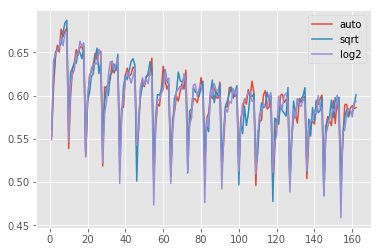

In [44]:
#dropped is the dataframe with numeric values
#selected is the one with all the selected variables

l.model_selection_random_forest(df_selected_1,df_target,train_features,train_outcome)

In [45]:
#fill in all the best parameters
w=50
best_model_1=RandomForestClassifier(bootstrap='true',max_features='auto',min_samples_split=10,n_estimators=9,class_weight={0: 1, 1: w,2:w,3:w})
best_model_1.fit(train_features,train_outcome) #79.7

RandomForestClassifier(bootstrap='true',
            class_weight={0: 1, 1: 50, 2: 50, 3: 50}, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [46]:
#cross validation by our best model
l.cross_val(test_features,test_outcome,best_model_1)

0.7420718816067653

In [47]:
#see the accuracy score
accuracy_score(test_outcome, best_model_1.predict(test_features))


0.7972350230414746

In [ ]:
#see the predictions
best_model_1.predict(test_features)

In [48]:
#the result of confusion matrix
from sklearn.metrics import confusion_matrix
y_pred=best_model_1.predict(test_features)
#confusion_matrix(test_outcome, y_pred)

In [49]:
#the F1 score, 
from sklearn.metrics import f1_score
f1_score(test_outcome, y_pred,average="weighted")

0.7651930051416788

### Multi-layer Perceptron
- For the MLP classifier, we defined several parameters within a GridSearch to select the best MLP model. These parameters included `activation`, `learning_rate`, `hidden_layer_sizes`, and the `solver`. We set the activation to choose between relu and logistic because these are able to converge the fastest and generally give good predictions for smaller data sets. We wanted adaptive learning to see if the model could pick up on any complex changes in the sampling of data. We also let the model choose between a couple solvers that we saw provided the highest scores. As for the hidden layer sizes, they roughly follow the width of our data and seemed to perform better than other iterations of the model. We also made sure the MLP classifier shuffled samples and used cross validation to ensure accuracy. For feature selection, we decided to use _Select K Best_ with the `f_classif` solver and wanted anywhere from 5 to 25 (the width of our data) features. Before the model is ran we also used a Robust Scaler for data normalization and used the default (25, 75) or Inter-Quartile Range parameter. Shown below, we can see the results generated from this model. 

In [132]:
import MLP as m;
from sklearn.metrics import accuracy_score

In [133]:
clf = m.mlp.fit(tr_feat, tr_out)
t = clf.predict(test_feat).round()
print('Accuracy Score with four categories: ' + str(round(accuracy_score(test_out, t), 2)))

Accuracy Score with four categories: 0.71


Here we can see that our model accuracy is pretty low. Part of this could be the fact that we can't use class weights to address the imbalance of our data set. The MLP model could also just be an inadequate assessor of what we are trying to achieve. 

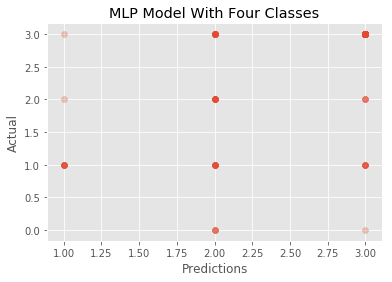

In [134]:
plt.title('MLP Model With Four Classes')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.scatter(t, test_out, alpha=0.1);

Looking at the predictions this model is making we can see where it's making mistake. The model fails to predict any of the `mostly false` articles correctly. In fact, most of the outcomes are incorrectly predicted. It does ok with predicting when an article is `mostly true` but not with some error. We might be able to improve the accuracy if we go at the problem differently.  

In [135]:
clf = m.mlp.fit(tr2_feat, tr2_out)
t = clf.predict(test2_feat).round()
print('Accuracy Score with two categories: ' + str(round(accuracy_score(test2_out, t), 2)))

Accuracy Score with two categories: 0.8


This model groups the _Ratings_ `mostly false`, `mix of true and false`, and `no factual content` into one category. The reason behind this is that an article could be considered "fake news" or one that includes "misinformation" if it contains any false or opiniated information. This is especially true when the sole source of our articles are from _news sources_ because these are outlets we should trust to output truthful articles. With this change, we can see that our accuracy of the model has improved by almost 10% and is a noticeable step up.

### Linear Support Vector Classifier
- In our Linear Support Vector Classifier (Linear SVC), we tried to maximize our accuracy using the a number of parameters, including sklearn's MinMaxScaler to normalize our data, as well as SelectKBest to locate the top features to include in the model
- We ran both the dataset with four rating levels, and the dataset with two rating levels, through our Linear SVC model. Because Linear SVC works by grouping similar groups together, and because we have such an unbalanced dataset, combining the 3 rating levels that are technically fake news tremendously improves the score
- As in our Random Forest Classifier, we must utilize the class_weight parameter, so that we can improve our chances of correctly predicting articles that are in fact _Fake News_
- The scores we are achieving using Linear SVC are consistently between 76-81%, improvements might be able to be made if we did have a more balanced dataset, with more articles that are considered as Fake News


In [146]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import KFold


In [ ]:
# Split data into training and testing data
train_features, test_features, train_outcome, test_outcome = train_test_split(
   df_dropped,
   df_target,
   test_size=0.30
)

In [152]:
# Make pipeline with MinMaxScaler for normalization, SelectKBest for feature selection, LinearSVC as classifier
pipe = make_pipeline(MinMaxScaler(), SelectKBest(f_classif), LinearSVC())

# Param grid
param_grid = {'selectkbest__k':range(5,25)}

# Fit model and get score
grid = GridSearchCV(pipe, param_grid, cv = KFold(n_splits=10, shuffle=True))
grid.fit(tr2_feat, tr2_out)
print('Accuracy of Linear SVC: ' + str(grid.score(test2_feat, test2_out)))

Accuracy of Linear SVC: 0.7764976958525346


## Results

Overall, our models were able to predict whether a post was considered "fake news" between 70-80% of the time. This is fairly good considering there wasn't a plethera of features for us to work with. Moving forward it could be useful for us to use natural language processing to analyze some of the comments in the posts to get a sense of what people think of the post. There could be some important and meaningful information that we are missing out on and that could improve our model. Currently, our two best models were K Nearest Neighbors and the Multi-Layer Perceptron. Our test to see if changing the number of possiblities regarding the outcome did improve some of the models but didn't seem to greatly improve their performance. With that though, it's important to note that just because a post doesn't include factual content or includes some truthful content doesn't mean it can't be misleading. 